In [265]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd
from IPython.display import Markdown, display

In [126]:
def add_proposal_data_to_timeplot(ax, proposal_df, lines=(1,1,1,1,1)):
    from matplotlib.pyplot import cm
    line_types = [
        ((0, (1, 20)), 'submission'),
        ((0, (1, 10)), 'earliest possible execution'),
        ('dotted', 'schedule'),
        ((0, (5, 10)), 'possible execution time'),
        ('-', 'actual execution')
    ]
    
    ylim = ax.get_ylim()
    colors = cm.rainbow(np.linspace(0, 1, len(proposal_df)))

    used_line_types = []
    
    for i, proposal_id in enumerate(proposal_df.index):
        proposal = proposal_df.loc[proposal_id]

        submission_timestep = proposal.submittedAt
        if lines[0]:
            submission_time_line = ax.plot(
                np.repeat(submission_timestep, 2),
                [0, ylim[1]],
                linestyle=line_types[0][0],
                c=colors[i]
            )
            used_line_types.append(0)

        earliest_execution_timestep = submission_timestep + 5 * 24 / 3

        if lines[1]:
            early_execution_time_line = ax.plot(
                    np.repeat(earliest_execution_timestep, 2),
                    [0, ylim[1]],
                    linestyle=line_types[1][0],
                    c=colors[i]
                )
            used_line_types.append(1)
        
        schedule_timestep = proposal.scheduledAt
        if schedule_timestep > submission_timestep:
            if lines[2]:
                schedule_time_line = ax.plot(
                    np.repeat(schedule_timestep, 2),
                    [0, ylim[1]],
                    linestyle=line_types[2][0],
                    c=colors[i]
                )
                used_line_types.append(2)
            possible_execution_timestep = schedule_timestep + 3 * 24 / 3
            if lines[3]:
                possible_execution_time_line = ax.plot(
                    np.repeat(possible_execution_timestep, 2),
                    [0, ylim[1]],
                    linestyle=line_types[3][0],
                    c=colors[i]
                )
                used_line_types.append(3)

        execution_timestep = proposal.executedAt
        if execution_timestep > schedule_timestep:
            if lines[4]:
                real_execution_time_line = ax.plot(
                    np.repeat(execution_timestep, 2),
                    [0, ylim[1]],
                    linestyle=line_types[4][0],
                    c=colors[i]
                )
                used_line_types.append(4)
        ax.set_ylim(ylim)
    
    for i, color in enumerate(colors):
        ax.plot([],[], c=color, label=f'Proposal {proposal_df.index[i]}')
    for i in used_line_types:
        linestyle, label = line_types[i]
        ax.plot([],[], linestyle=linestyle, c='gray', label=label)

In [5]:
p_to_runs = Path("../../results/simulations/model_validation/")
df_tuples = {}
proposal_df_list, start_data_df_list, timestep_data_df_list = [], [], []
for i, p_to_tables in enumerate(p_to_runs.iterdir()):
    proposals_p = p_to_tables.joinpath("proposals.csv")
    start_data_p = p_to_tables.joinpath("start_data.csv")
    timestep_data_p = p_to_tables.joinpath("timestep_data.csv")
    if not proposals_p.exists() or not start_data_p.exists() or not timestep_data_p.exists():
        print(p_to_tables)
        continue
    proposals_df = pd.read_csv(proposals_p)
    proposals_df["unique_run_key"] = i
    proposal_df_list.append(proposals_df)
    start_data_df = pd.read_csv(start_data_p)
    start_data_df["unique_run_key"] = i
    start_data_df_list.append(start_data_df)
    timestep_data_df = pd.read_csv(timestep_data_p)
    timestep_data_df["unique_run_key"] = i
    timestep_data_df_list.append(timestep_data_df)

../../results/simulations/model_validation/2e55cb409a36e00dbbb01943349ea01e7fe31cfb4d68c0addd0a581e1cf39a96-2400
../../results/simulations/model_validation/ee4598dd81cb560448db4f75243e50d612183d6f6a6eeae67b187891bcba0098-2400
../../results/simulations/model_validation/22c34d2b63fdf29c1e6623e2d5c802a76c40cdab0846fff7d640fd7a7457b027-2400
../../results/simulations/model_validation/2aa223d2a76bd984cb04284153e88abc29eafac17a0824e00fba56116dc3ca13-2400
../../results/simulations/model_validation/1d70b9bfc8e64fcd3fa902fae47c5b7f58a8f99f886dcce5c99002bef54ee317-2400
../../results/simulations/model_validation/3e1c095f72fc239a5f8f498ac9d9836ef04e09f5f77a5e5ec133d79054c2f45e-2400


In [269]:
proposal_df_full = pd.concat(proposal_df_list)
start_data_df_full = pd.concat(start_data_df_list)
timestep_data_df_full = pd.concat(timestep_data_df_list)

##### Let's imagine that we have these dataframes and go from here

In [270]:
start_data_df_full["first_seal_rage_quit_support"] /= 10**16
start_data_df_full["second_seal_rage_quit_support"] /= 10**16
timestep_data_df_full = timestep_data_df_full.merge(start_data_df_full, on='unique_run_key', how='outer')
proposal_df_full = proposal_df_full.merge(start_data_df_full, on='unique_run_key', how='outer')

### Some stats

In [272]:
for first_seal_rage_quit_support in sorted(proposal_df_full.first_seal_rage_quit_support.unique()):
    view = proposal_df_full[proposal_df_full.first_seal_rage_quit_support == first_seal_rage_quit_support]
    not_cancelled_count = view.cancelledAt.isna().sum()
    executed_count = (view.executedAt > 0).sum()
    total_count = len(view)
    runs_count = len(view["unique_run_key"].unique())
    

    veto_view = timestep_data_df_full[(timestep_data_df_full['dg_state_value'] == 2) & (timestep_data_df_full['first_seal_rage_quit_support'] == first_seal_rage_quit_support)]
    time_in_veto_df = veto_view.groupby(
    ['second_seal_rage_quit_support',
     'seed']
    ).count().reset_index()
    time_in_veto_mean = time_in_veto_df.timestep.mean() * 3
    time_in_veto_std = time_in_veto_df.timestep.std() * 3

    time_to_veto_df = veto_view.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['dg_state_value'] == 2].iloc[0]).reset_index(drop=True)
    time_before_veto_mean = time_to_veto_df.timestep.mean() * 3
    time_before_veto_std = time_to_veto_df.timestep.std() * 3

    display(Markdown(f"#### First Seal Rage Quit Support: **{first_seal_rage_quit_support}**"))
    display(Markdown(f"##### Runs count: **{runs_count}**"))
    display(Markdown(f"##### Not cancelled proposals: **{not_cancelled_count}**  (**{not_cancelled_count / total_count:.2f}%**)"))
    display(Markdown(f"##### Executed proposals: **{executed_count}**  (**{executed_count / total_count:.2f}%**)"))
    display(Markdown(f"##### Time before veto (mean+std): **{time_before_veto_mean:.0f}+{time_before_veto_std:.0f} hours**"))
    display(Markdown(f"##### Time in veto (mean+std): **{time_in_veto_mean:.0f}+{time_in_veto_std:.0f} hours**"))

#### First Seal Rage Quit Support: **1.0**

##### Runs count: **15**

##### Not cancelled proposals: **42**  (**1.00%**)

##### Executed proposals: **42**  (**1.00%**)

##### Time before veto (mean+std): **1190+751 hours**

##### Time in veto (mean+std): **4232+569 hours**

#### First Seal Rage Quit Support: **3.0**

##### Runs count: **12**

##### Not cancelled proposals: **72**  (**1.00%**)

##### Executed proposals: **72**  (**1.00%**)

##### Time before veto (mean+std): **2041+1686 hours**

##### Time in veto (mean+std): **3600+1028 hours**

#### First Seal Rage Quit Support: **5.0**

##### Runs count: **12**

##### Not cancelled proposals: **132**  (**1.00%**)

##### Executed proposals: **132**  (**1.00%**)

##### Time before veto (mean+std): **1975+945 hours**

##### Time in veto (mean+std): **4182+807 hours**

### Single run plots

In [204]:
run_id = 10

timestep_data_df_run = timestep_data_df_full[timestep_data_df_full["unique_run_key"] == run_id].copy()
start_data_df_run = start_data_df_full[start_data_df_full["unique_run_key"] == run_id].copy()
proposal_df_run = proposal_df_full[proposal_df_full["unique_run_key"] == run_id].copy()

#### Actor reaction speed distribution

Text(0.5, 1.0, 'Actors reaction speed')

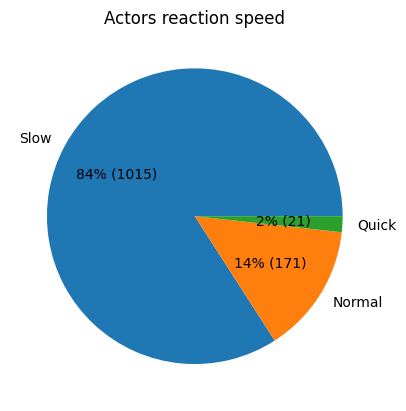

In [205]:
start_data_df_run["Attackers"] = start_data_df_run["SingleAttacker"] + start_data_df_run["CoordinatedAttacker"] + start_data_df_run["Hacker"]

cols = ["Slow", "Normal", "Quick", "Attackers"]
values = np.array(start_data_df_run[cols])[0]
values[2] = values[2] - values[3]

if values[3] == 0:
    cols.pop()
    values = values[:-1]

n_actors = start_data_df_run["n_actors"]

fmt = lambda x: f"{int(x.round())}% ({int((x * n_actors / 100).round())})"
plt.pie(values, labels=cols, autopct=fmt)
plt.title("Actors reaction speed")

In [278]:
timestep_data_df_run_start = timestep_data_df_run[timestep_data_df_run["timestep"] == 1]


21600    0.0
Name: balance_SingleAttacker, dtype: float64

Text(0.5, 1.0, 'Tokens by reaction speed')

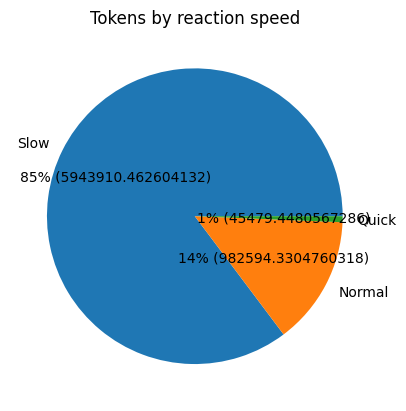

In [282]:
timestep_data_df_run_start = timestep_data_df_run[timestep_data_df_run["timestep"] == 1].copy()

attacker_labels = ["SingleAttacker", "CoordinatedAttacker", "Hacker"]
timestep_data_df_run_start["balance_Attackers"] = sum(timestep_data_df_run_start[attacker_label] for attacker_label in attacker_labels)

cols = ["Slow", "Normal", "Quick", "Attackers"]
values = np.array(timestep_data_df_run_start[[f"balance_{col}" for col in cols]])[0]
values[2] = values[2] - values[3]

if values[3] == 0:
    cols.pop()
    values = values[:-1]

initial_tokens = timestep_data_df_run_start["total_balance"].sum()

fmt = lambda x: f"{int(x.round())}% ({x * initial_tokens / 100})"
plt.pie(values, labels=cols, autopct=fmt)
plt.title("Tokens by reaction speed")

#### System state, health and tokens

In [206]:
initial_tokens = timestep_data_df_run.loc[timestep_data_df_run["timestep"] == 1, "total_balance"].sum()
initial_hp = timestep_data_df_run.loc[timestep_data_df_run["timestep"] == 1, "total_health"].sum()

timestep_data_df_run["total_balance_relative"] = timestep_data_df_run["total_balance"] / initial_tokens * 100
timestep_data_df_run["total_locked_relative"] = timestep_data_df_run["total_locked"] / initial_tokens * 100
timestep_data_df_run["total_health_relative"] = timestep_data_df_run["total_health"] / initial_hp * 100

veto_threshold = start_data_df_run["first_seal_rage_quit_support"]
ragequit_threshold = start_data_df_run["second_seal_rage_quit_support"]

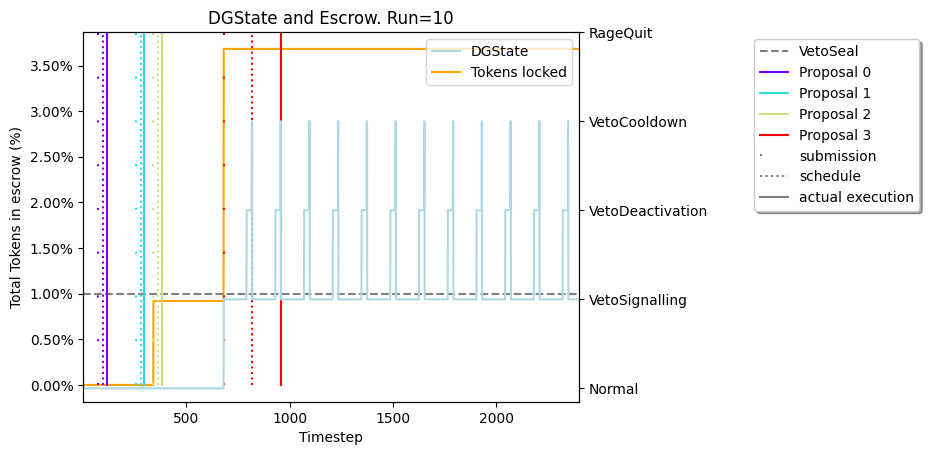

In [207]:
fig, ax = plt.subplots()

sns.lineplot(timestep_data_df_run, x="timestep", y="total_locked_relative", color='orange', ax=ax, label="Tokens locked")
xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle='--', color='gray', label='VetoSeal')
ax.set_xlim(xlim)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax2 = ax.twinx()
sns.lineplot(data=timestep_data_df_run, x="timestep", y="dg_state_value", color='lightblue', ax=ax2, label="DGState")
ax2.set_yticks([1,2,3,4,5], ["Normal", "VetoSignalling", "VetoDeactivation", "VetoCooldown", "RageQuit"]);

add_proposal_data_to_timeplot(ax, proposal_df_run, [1,0,1,0,1])
handles, labels = ax.get_legend_handles_labels()
by_label_ax = dict(zip(labels, handles))
handles2, labels2 = ax2.get_legend_handles_labels()
by_label_ax2 = dict(zip(labels2, handles2))
by_label_ax2["Tokens locked"] = by_label_ax["Tokens locked"]
del by_label_ax["Tokens locked"]
ax.legend(by_label_ax.values(), by_label_ax.keys(), bbox_to_anchor=(1.7, 1), fancybox=True, shadow=True);
ax2.legend(by_label_ax2.values(), by_label_ax2.keys());

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Total Tokens in escrow (%)")
ax.set_title(f"DGState and Escrow. Run={run_id}");

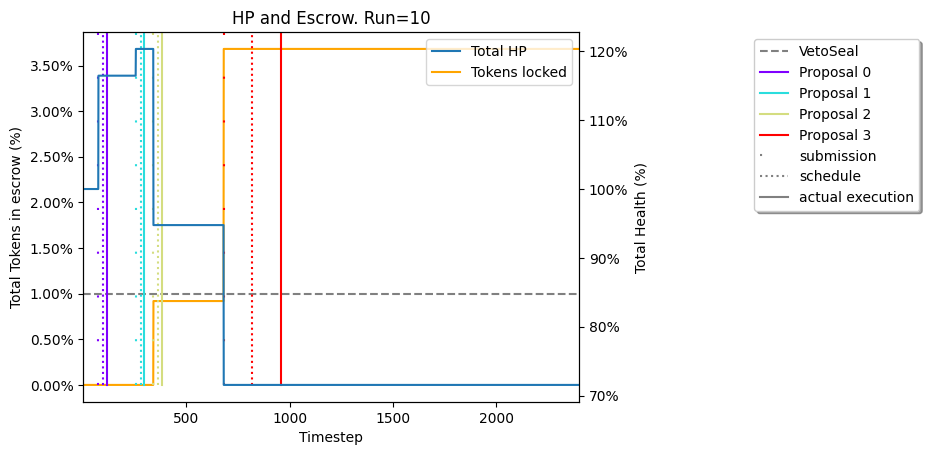

In [208]:
fig, ax = plt.subplots()

sns.lineplot(timestep_data_df_run, x="timestep", y="total_locked_relative", color='orange', ax=ax, label="Tokens locked")
xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle='--', color='gray', label='VetoSeal')
ax.set_xlim(xlim)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax2 = ax.twinx()
sns.lineplot(data=timestep_data_df_run, x="timestep", y="total_health_relative", ax=ax2, label="Total HP")
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

add_proposal_data_to_timeplot(ax, proposal_df_run, [1,0,1,0,1])

handles, labels = ax.get_legend_handles_labels()
by_label_ax = dict(zip(labels, handles))
handles2, labels2 = ax2.get_legend_handles_labels()
by_label_ax2 = dict(zip(labels2, handles2))
by_label_ax2["Tokens locked"] = by_label_ax["Tokens locked"]
del by_label_ax["Tokens locked"]
ax.legend(by_label_ax.values(), by_label_ax.keys(), bbox_to_anchor=(1.7, 1), fancybox=True, shadow=True);
ax2.legend(by_label_ax2.values(), by_label_ax2.keys());

ax.set_xlabel("Timestep")
ax2.set_ylabel("Total Health (%)")
ax.set_ylabel("Total Tokens in escrow (%)")
ax.set_title(f"HP and Escrow. Run={run_id}");

In [209]:
timestep_data_df_run.columns

Index(['unique_run_key', 'timestep', 'dg_state_value', 'dg_state_name',
       'dg_dynamic_timelock_seconds', 'total_balance', 'total_locked',
       'total_health', 'total_actors', 'balance_Normal', 'balance_Quick',
       'balance_Slow', 'balance_NoReaction', 'balance_BaseActor',
       'balance_HonestActor', 'balance_SingleAttacker',
       'balance_CoordinatedAttacker', 'balance_Hacker',
       'balance_SingleDefender', 'balance_CoordinatedDefender',
       'locked_Normal', 'locked_Quick', 'locked_Slow', 'locked_NoReaction',
       'locked_BaseActor', 'locked_HonestActor', 'locked_SingleAttacker',
       'locked_CoordinatedAttacker', 'locked_Hacker', 'locked_SingleDefender',
       'locked_CoordinatedDefender', 'health_Normal', 'health_Quick',
       'health_Slow', 'health_NoReaction', 'health_BaseActor',
       'health_HonestActor', 'health_SingleAttacker',
       'health_CoordinatedAttacker', 'health_Hacker', 'health_SingleDefender',
       'health_CoordinatedDefender', 'seed', '

#### System state, health and tokens by reaction speed

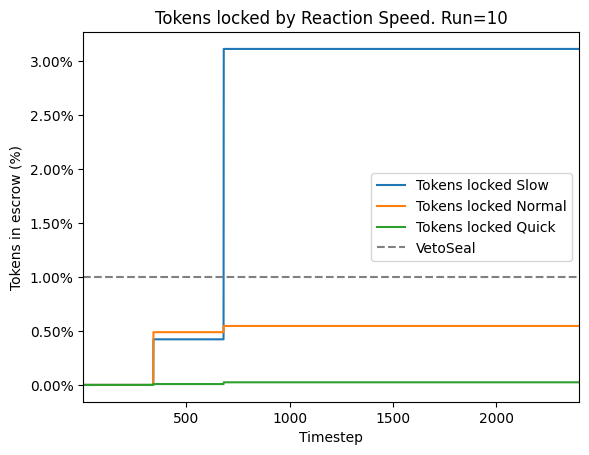

In [210]:
fig, ax = plt.subplots()
speed_labels = ["Slow", "Normal", "Quick"]
for speed_label in speed_labels:
    col_name = f"locked_{speed_label}_relative"
    timestep_data_df_run[col_name] = timestep_data_df_run[f"locked_{speed_label}"] / initial_tokens * 100
    sns.lineplot(timestep_data_df_run, x="timestep", y=col_name, ax=ax, label=f"Tokens locked {speed_label}")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle='--', color='gray', label='VetoSeal')
ax.set_xlim(xlim)

ax.legend()

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Tokens in escrow (%)")

ax.set_title(f"Tokens locked by Reaction Speed. Run={run_id}");

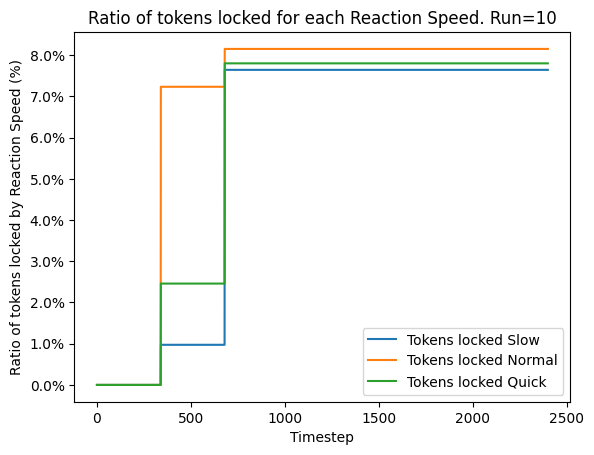

In [211]:
fig, ax = plt.subplots()
speed_labels = ["Slow", "Normal", "Quick"]
for speed_label in speed_labels:
    initial_tokens_speed = timestep_data_df_run[f"balance_{speed_label}"]
    
    col_name = f"locked_{speed_label}_relative"
    timestep_data_df_run[col_name] = timestep_data_df_run[f"locked_{speed_label}"] / initial_tokens_speed * 100
    sns.lineplot(timestep_data_df_run, x="timestep", y=col_name, ax=ax, label=f"Tokens locked {speed_label}")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax.legend()

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Ratio of tokens locked by Reaction Speed (%)")

ax.set_title(f"Ratio of tokens locked for each Reaction Speed. Run={run_id}");

### Multiple run plots (static parameters)

In [260]:
vetoseal = timestep_data_df_full["first_seal_rage_quit_support"].unique()[2]
rageseal = timestep_data_df_full["second_seal_rage_quit_support"].unique()[0]
timestep_data_df_params = timestep_data_df_full[
        (timestep_data_df_full["first_seal_rage_quit_support"] == vetoseal)
        & (timestep_data_df_full["second_seal_rage_quit_support"] == rageseal)
    ].copy()

initial_tokens = timestep_data_df_params.loc[timestep_data_df_params["timestep"] == 1, "total_balance"].iloc[0]
timestep_data_df_params["total_locked_relative"] = timestep_data_df_params["total_locked"] / initial_tokens * 100

Text(0.5, 1.0, 'Escrow and DGState dynamics in different runs. VetoSeal=1.0, RageSeal=10.0')

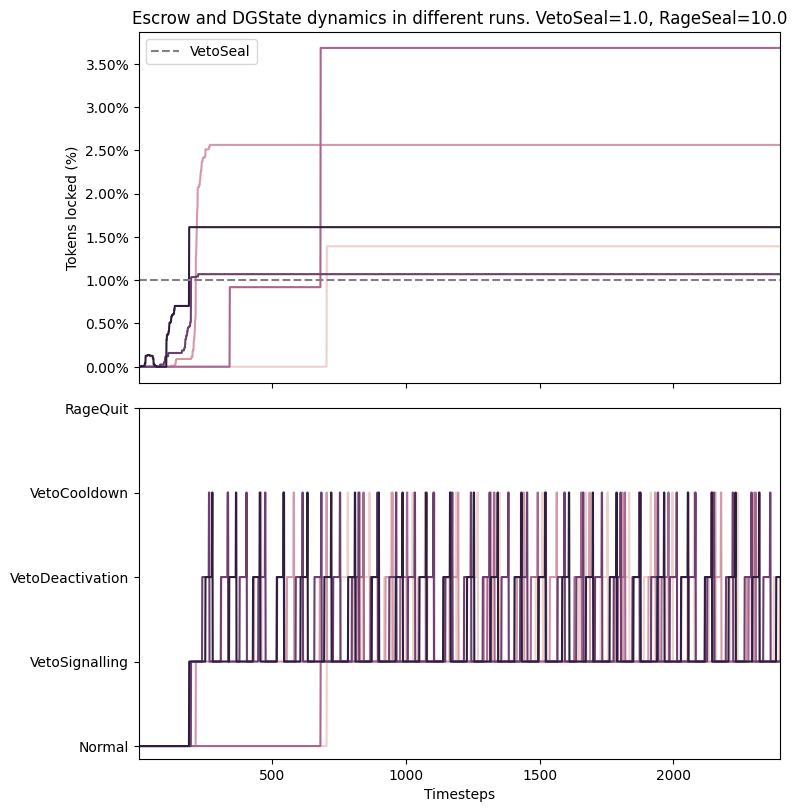

In [261]:
nrows = 2
ncols = 1
basesize = 4
figsize = (basesize * ncols * 2, basesize * nrows)
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=figsize)

ax = axes[0]
g = sns.lineplot(timestep_data_df_params, x="timestep", y="total_locked_relative", ax=ax, hue="seed")
ax.legend().remove()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

xlim = timestep_data_df_params["timestep"].min(), timestep_data_df_params["timestep"].max()
line, = ax.plot(xlim, np.repeat(vetoseal, 2), linestyle='--', color='gray', label='VetoSeal')
ax.set_xlim(xlim)

ax.legend([line], [line.get_label()])

ax.set_xlabel("")
ax.set_ylabel("Tokens locked (%)")

ax2 = axes[1]
g = sns.lineplot(timestep_data_df_params, x="timestep", y="dg_state_value", ax=ax2, hue="seed")
ax2.legend().remove()
ax2.set_yticks([1,2,3,4,5], ["Normal", "VetoSignalling", "VetoDeactivation", "VetoCooldown", "RageQuit"]);
ax2.set_xlabel("Timesteps")
ax2.set_ylabel("")
fig.tight_layout()

ax.set_title(f"Escrow and DGState dynamics in different runs. VetoSeal={vetoseal}, RageSeal={rageseal}")

### Parameter sweep plots